In [154]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
import rl_equation_solver
from rl_equation_solver.environment.algebraic import Env
from rl_equation_solver.agent.dqn import Agent as AgentDQN
from rl_equation_solver.agent.gcn import Agent as AgentGCN
from rl_equation_solver.agent.lstm import Agent as AgentLSTM
from rl_equation_solver.utilities import utilities
from rl_equation_solver.utilities.utilities import GraphEmbedding
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from rex import init_logger
from sympy import symbols, sqrt, simplify, expand, nsimplify, parse_expr, sympify
import sympy

In [156]:
init_logger(__name__, log_level='DEBUG')
init_logger('rl_equation_solver', log_level="DEBUG")

<Logger rl_equation_solver (DEBUG)>

In [ ]:
# plot reward distribution
def plot_reward_dist(env):
    fig, ax = plt.subplots(1, 1)
    ax.hist(env.avg_history['reward'])
    ax.set_ylabel('Count')
    ax.set_xlabel('Reward')
    plt.show()

# plot complexity, loss, reward
def plot_trends(env):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    x = np.arange(len(env.avg_history['ep']))
    
    y = env.avg_history['complexity']
    a, b = np.polyfit(x, y, 1)
    ax[0].scatter(x, y)
    ax[0].plot(a*x + b, color='r')
    
    y = env.avg_history['loss']
    mask = np.array([i for i, v in enumerate(y) if not np.isnan(v)])
    mask = slice(mask[0], mask[-1] + 1)
    a, b = np.polyfit(x[mask], y[mask], 1)
    ax[1].scatter(x[mask], y[mask])
    ax[1].plot(a*x[mask] + b, color='r')
    
    y = env.avg_history['reward']
    a, b = np.polyfit(x, y, 1)
    ax[2].scatter(x, y)
    ax[2].plot(a*x + b, color='r')
    
    ax[0].set_title('Complexity')
    ax[1].set_title('Loss')
    ax[2].set_title('Reward')
    plt.show()
    

## Initialize Env and Agent ##
### Agent can be AgentGCN, AgentLSTM, AgentDQN ###

In [157]:
env = Env(order=2, init_state=symbols('0'))
agent = AgentGCN(env, device='cuda:0')

INFO - 2023-04-16 18:57:46,583 [algebraic.py:109] : Initializing environment with order=2, |S| = 15 x 128 = 1920
INFO - 2023-04-16 18:57:46,586 [gcn.py:37] : Initialized Agent with device cuda:0


## Train Agent ##

In [168]:
for _ in range(10):
    agent.train(5)

INFO - 2023-04-16 19:17:04,836 [base.py:299] : Running training routine for 50 episodes in eval=False mode.
INFO - 2023-04-16 19:17:14,853 [history.py:55] : {'ep': 72, 'step': 8208, 'complexity': 27, 'loss': '3.391e+00', 'reward': '0.000e+00', 'state': (1 - a1)/a0**43}
INFO - 2023-04-16 19:17:14,914 [base.py:343] : Solver terminated after 91 steps with reward -2.600e+01 and mean loss 3.613e+00. Final state = (1 - a1)/a0**43
INFO - 2023-04-16 19:17:14,915 [history.py:55] : {'ep': 72, 'step': 8209, 'complexity': 35, 'loss': '3.559e+00', 'reward': '-8.000e+00', 'state': (1 - a1)/a0**43}
INFO - 2023-04-16 19:17:16,062 [history.py:55] : {'ep': 73, 'step': 8220, 'complexity': 27, 'loss': '3.274e+00', 'reward': '0.000e+00', 'state': (1 - a1)/a0**9}
INFO - 2023-04-16 19:17:16,105 [base.py:343] : Solver terminated after 12 steps with reward -2.600e+01 and mean loss 3.340e+00. Final state = (1 - a1)/a0**9
INFO - 2023-04-16 19:17:16,106 [history.py:55] : {'ep': 73, 'step': 8221, 'complexity': 35,

## Plot Reward Distribution ##

In [ ]:
plot_reward_dist(env)

## Plot complexity, loss, and reward trend ##

c:\users\bbent\repos\rl-equation-solver\rl_equation_solver\utilities\history.py:28: RuntimeWarning: Mean of empty slice
  return out


Text(0.5, 0, 'Reward')

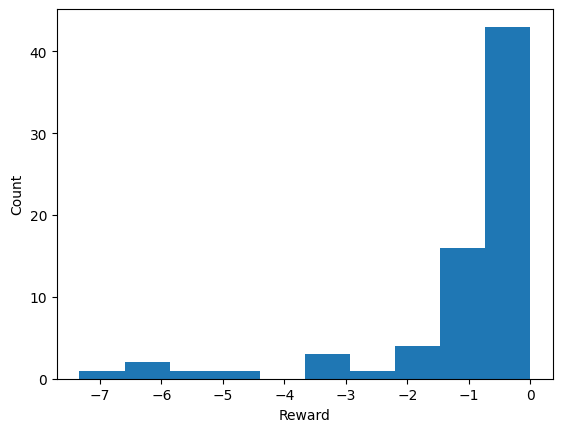

In [167]:
fig, ax = plt.subplots(1, 1)
ax.hist(env.avg_history['reward'])
ax.set_ylabel('Count')
ax.set_xlabel('Reward')

## Plot complexity, loss, and reward trend ##

Text(0.5, 1.0, 'Reward')

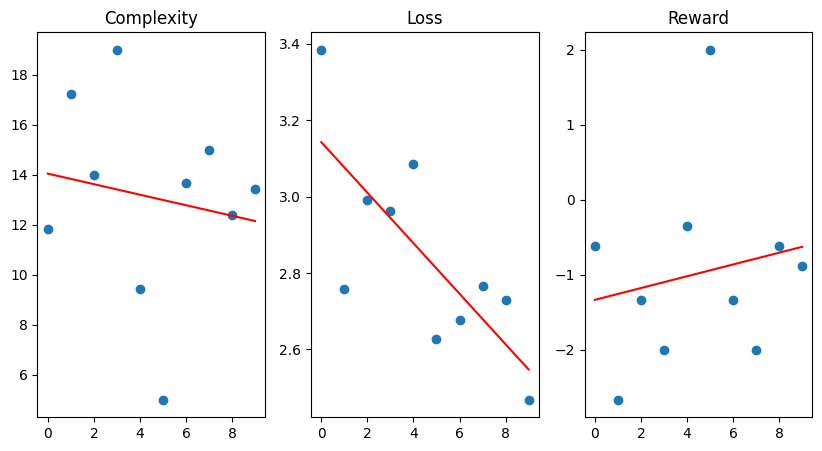

In [118]:
plot_trends(env)


## Run trained agent in eval mode ##

In [ ]:
agent.train(10, eval=True)

## Plot reward distribution for trained agent ##

In [ ]:
plot_reward_dist(env)

## Render final state graph ##

In [121]:
agent.train(10, eval=True)

INFO - 2023-04-16 18:43:42,439 [base.py:299] : Running training routine for 10 episodes in eval=True mode.
INFO - 2023-04-16 18:43:43,041 [history.py:57] : {'ep': 0, 'step': 296, 'complexity': 17, 'loss': '2.771e+00', 'reward': '-8.000e+00', 'state': a0 - a1}
INFO - 2023-04-16 18:43:43,083 [base.py:343] : Solver terminated after 8 steps with reward -8.000e+00 and mean loss 2.707e+00. Final state = a0 - a1
INFO - 2023-04-16 18:43:43,088 [history.py:57] : {'ep': 0, 'step': 297, 'complexity': 17, 'loss': '3.098e+00', 'reward': '0.000e+00', 'state': a0 - a1}
INFO - 2023-04-16 18:43:43,865 [history.py:57] : {'ep': 1, 'step': 305, 'complexity': 23, 'loss': '3.517e+00', 'reward': '-4.000e+00', 'state': 1 - a1 + 2}
INFO - 2023-04-16 18:43:43,907 [base.py:343] : Solver terminated after 9 steps with reward -1.400e+01 and mean loss 2.616e+00. Final state = 1 - a1 + 2
INFO - 2023-04-16 18:43:43,912 [history.py:57] : {'ep': 1, 'step': 306, 'complexity': 23, 'loss': '3.245e+00', 'reward': '0.000e+00

KeyboardInterrupt: 

## Plot reward distribution for trained agent ##

Text(0.5, 0, 'Reward')

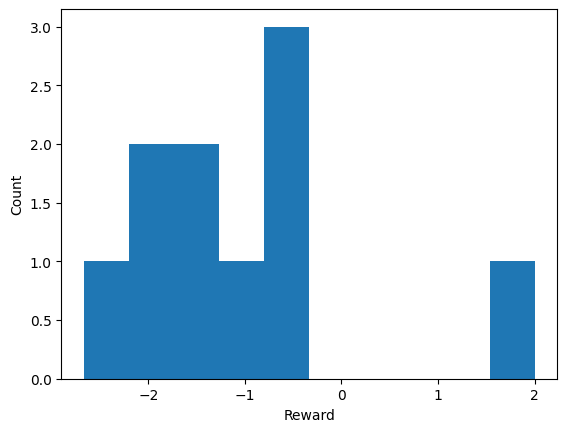

In [117]:
fig, ax = plt.subplots(1, 1)
ax.hist(env.avg_history['reward'])
ax.set_ylabel('Count')
ax.set_xlabel('Reward')

## Render final state graph ##

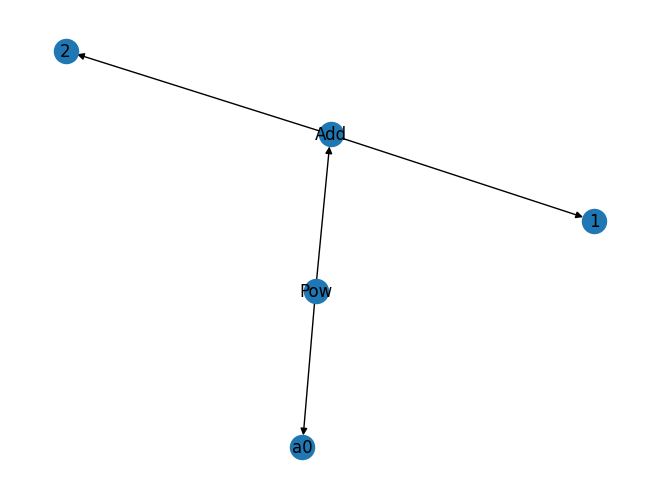

In [119]:
nx.draw(env.state_graph, labels=env.node_labels)

## Run new Agent in eval mode ##

In [ ]:
env = Env(order=2)
agent = AgentGCN(env, device='cuda:0')
agent.train(10, eval=True)

## Plot reward distribution for untrained agent ##

In [ ]:
plot_reward_dist(env)